In [20]:
import logging
import sys

import category_encoders as ce
from alive_progress import alive_bar
from lightgbm import LGBMClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.preprocessing import Normalizer, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import get_scorer_names

# from src.pipeline_functions.train_model_functions import *
from typing import Dict, Tuple, List

import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.base import BaseEstimator
from sklearn.metrics import (
    make_scorer,
    matthews_corrcoef,
    jaccard_score,
    average_precision_score,
    fbeta_score,
)
from sklearn.model_selection import BaseCrossValidator, RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from joblib import Parallel, delayed
import pickle
import gzip
import yaml
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt

In [2]:
browser_one = "chrome"
date_one = "08_12_2022"
train_data_file_name = 'train_set_featurized_BE'
strategy = "BE"
experiment_name = f"tuning_one_test"
dir_path_one = f"{browser_one}/{date_one}"

dir_path_one = f"../data/processed/{dir_path_one}/{train_data_file_name}"
result_csv_filename = f"models/result_metrics/{experiment_name}.csv"

In [11]:
def train_models(
        models: Dict[str, BaseEstimator],
        train_data_file_path: str,
        cv: RepeatedStratifiedKFold,
        clf_preprocessor: ColumnTransformer = None,
) -> pd.DataFrame:
    all_mean_metrics = {}
    scoring_metrics = {
        "accuracy": "accuracy",
        "roc_auc": "roc_auc",
        "f1": "f1",
        "balanced_accuracy": "balanced_accuracy",
        "precision": "precision",
        "recall": "recall",
        "neg_log_loss": "neg_log_loss",
        "mcc": make_scorer(matthews_corrcoef),
        "jaccard": make_scorer(jaccard_score),
        "aupcr": make_scorer(average_precision_score),
        "fbeta": make_scorer(fbeta_score, beta=0.5),
    }

    train_data = pd.read_parquet(f"{train_data_file_path}.parquet.gzip")
    X_train, y_train = train_data.iloc[:, :-1], train_data["tracker"]

    for model_name, model in models.items():
        print(f"Training {model_name}...")

        if type(clf_preprocessor) is not None:
            clf_pipeline = Pipeline(
                steps=[("preprocessor", clf_preprocessor),
                       ("classifier", model)]
            )
        else:
            clf_pipeline = Pipeline(steps=[("classifier", model)])

        cv_results = cross_validate(
            clf_pipeline,
            X_train,
            y_train,
            cv=cv,
            scoring=scoring_metrics,
            return_estimator=True,
            n_jobs=-1,
        )
        mean_cv_metrics = {
            metric: np.mean(cv_results["test_" + metric])
            for metric in scoring_metrics.keys()
        }
        all_mean_metrics[model_name] = mean_cv_metrics

        best_estimator_idx = np.argmax(cv_results["test_roc_auc"])
        best_estimator = cv_results["estimator"][best_estimator_idx]

    return pd.DataFrame(all_mean_metrics).T

In [43]:
def tune_hyperparameters(models, hyperparameters, X, y, method="grid_search",
                         n_iter=100):
    best_params = {}

    for model_name, model in models.items():
        print(f"Tuning {model_name}...")
        if model_name in hyperparameters:
            if method == "grid_search":
                search = GridSearchCV(model, hyperparameters[model_name], cv=5,
                                      scoring='matthews_corrcoef', n_jobs=-1)
            elif method == "random_search":
                search = RandomizedSearchCV(model, hyperparameters[model_name],
                                            cv=5, scoring='matthews_corrcoef', n_jobs=-1,
                                            n_iter=n_iter)
            else:
                raise ValueError(
                    "Invalid method. Expected one of: 'grid_search', 'random_search'")

            search.fit(X, y)
            best_params[model_name] = search.best_params_
        else:
            print(f"No hyperparameters provided for {model_name}, skipping")

    return best_params

In [5]:
def parse_parameters(params):
    # List of parameters that should be integers
    int_parameters = ["max_depth", "min_samples_split", "min_samples_leaf"]
    for key, value in params.items():
        if isinstance(value, list):
            new_values = []
            for v in value:
                # check if the item is a nested list
                if isinstance(v, list):
                    new_sub_values = []
                    for sub_v in v:
                        new_sub_values.append(
                            convert_to_number_or_keep_str(sub_v, key,
                                                          int_parameters))
                    new_values.append(new_sub_values)
                else:
                    new_values.append(
                        convert_to_number_or_keep_str(v, key, int_parameters))
            params[key] = new_values
        elif isinstance(value, dict):
            params[key] = parse_parameters(value)
    return params


def convert_to_number_or_keep_str(value, param_name, int_parameters):
    try:
        if param_name in int_parameters:
            return int(value)
        else:
            return float(value)
    except ValueError:
        return value


In [52]:
def train_models_run(
        train_data_file_path: str,
        strategy: str,
        result_csv_filename: str,
) -> pd.DataFrame:
    train_data = pd.read_parquet(f"{train_data_file_path}.parquet.gzip")

    X_train, y_train = train_data.iloc[:, :-1], train_data[["tracker"]]

    models = {
        "Logistic_Regression": LogisticRegression(
            random_state=10,
            n_jobs=-1,
            max_iter=1000,
            solver='newton-cholesky',
        ),
        "Gaussian_NB": GaussianNB(),
        # "Bernoulli_NB": BernoulliNB(force_alpha=True),
        "Decision_Tree": DecisionTreeClassifier(random_state=10),
        "Random_Forest": RandomForestClassifier(
                n_estimators=100,
                n_jobs=-1,
                random_state=10,
                max_features=None
            ),
    }

    cv = RepeatedStratifiedKFold(random_state=10, n_splits=5, n_repeats=1)

    # with open('hyperparameters.yaml', 'r') as f:
    #     hyperparameters = yaml.safe_load(f)

    PARAMS = {
        "Logistic_Regression":
            {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
             "class_weight": ['balanced', None]},
        "Gaussian_NB":
            {"var_smoothing": [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9,
                               1e-10, 1e-11,
                               1e-12, 1e-13, 1e-14, 1e-15]},
        # "Bernoulli_NB":
        #     {"alpha": [0.0, 0.5, 1.0],
        #      "binarize": [0.0, 0.5, 1.0],
        #      "class_prior": [None, [.1, .9], [.2, .8], [.3, .7], [.4, .6], [.5, .5],
        #                      [.6, .4], [.7, .3], [.8, .2], [.9, .1]], },
        "Decision_Tree":
            {"max_depth": [2, 4, 6, 8, 10, 100, 1000, None],
             "min_samples_split": [2, 5, 10, 20],
             "min_samples_leaf": [1, 2, 4],
             "class_weight": ['balanced', None]},
        "Random_Forest":
            {"n_estimators": [10, 50, 100, 200],
             "max_depth": [2, 4, 6, 8, 10, None],
             "class_weight": ['balanced', 'balanced_subsample', None],
             "criterion":['gini', 'log_loss'],}
    }

    best_params = tune_hyperparameters(models, PARAMS, X_train,
                                       y_train['tracker'],
                                       method="random_search", n_iter=50)

    models = {
        "Logistic_Regression": LogisticRegression(
            **best_params["Logistic_Regression"],
            random_state=10,
            max_iter=1000,
            solver='newton-cholesky',
        ),
        "Gaussian_NB": GaussianNB(
            **best_params["Gaussian_NB"]
        ),
        # "Bernoulli_NB": BernoulliNB(
        #     **best_params["Bernoulli_NB"]
        # ),
        "Decision_Tree": DecisionTreeClassifier(
            **best_params["Decision_Tree"],
            random_state=10
        ),
        "Random_Forest": RandomForestClassifier(
            **best_params["Random_Forest"],
            random_state=10
        ),
    }

    return train_models(
        models, train_data_file_path, cv)

In [7]:
models = {
    "Logistic_Regression": LogisticRegression(
        random_state=10,
        n_jobs=-1,
        max_iter=1000,
        solver='newton-cholesky'
    ),
    "Gaussian_NB": GaussianNB(),
    "Bernoulli_NB": BernoulliNB(),
    "Decision_Tree": DecisionTreeClassifier(random_state=10),
    # "Random_Forest": RandomForestClassifier(
    #     n_estimators=100,
    #     n_jobs=-1,
    #     random_state=10,
    #     criterion="gini",
    #     max_features=None
    # ),
    # "Extra_Trees_Classifier": ExtraTreesClassifier(random_state=10,
    #                                                n_jobs=-1),
    # "Ada_Boost": AdaBoostClassifier(random_state=10),
    # "Gradient_Boosting": GradientBoostingClassifier(random_state=10),
    # "LightGBM": LGBMClassifier(random_state=10, n_jobs=-1),
    # "Hist_GB": HistGradientBoostingClassifier(random_state=10),
    # "XGBoost": XGBClassifier(
    #     random_state=10,
    #     eval_metric="logloss",
    #     n_jobs=-1,
    # ),
}

In [8]:
cv = RepeatedStratifiedKFold(random_state=10, n_splits=5, n_repeats=5)

In [13]:
train_models(models, dir_path_one, cv)

Training Logistic_Regression...
Training Gaussian_NB...


/Users/wolfrieder/Documents/github_repos/thesis_project_v2/venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training Bernoulli_NB...
Training Decision_Tree...


/Users/wolfrieder/Documents/github_repos/thesis_project_v2/venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,accuracy,roc_auc,f1,balanced_accuracy,precision,recall,neg_log_loss,mcc,jaccard,aupcr,fbeta
Logistic_Regression,0.892746,0.952288,0.812177,0.859550,0.850410,0.777237,-0.248447,0.738795,0.683757,0.727434,0.834692
Gaussian_NB,0.852158,0.906414,0.758458,0.830802,0.740109,0.777848,-2.509392,0.652506,0.610921,0.641952,0.747329
Bernoulli_NB,0.849276,0.917999,0.754705,0.828551,0.733513,0.777160,-0.627624,0.646616,0.606050,0.636546,0.741846
Decision_Tree,0.964276,0.987346,0.939487,0.954279,0.949705,0.929490,-0.286175,0.914257,0.885882,0.903778,0.945591


In [37]:
import warnings

In [38]:
warnings.filterwarnings('ignore')

In [ ]:
%%time
train_models_run(dir_path_one, strategy, result_csv_filename)

Tuning Logistic_Regression...
Tuning Gaussian_NB...
Tuning Decision_Tree...
Tuning Random_Forest...


In [2]:
models = [
            "Logistic_Regression",
            "Gaussian_NB",
            "Bernoulli_NB",
            "Decision_Tree",
            "Random_Forest",
            "Extra_Trees_Classifier",
            "Ada_Boost",
            "Gradient_Boosting",
            "LightGBM",
            "Hist_GB",
            "XGBoost",
        ]

In [5]:
filename = f"{models[4]}_BE.sav.gz"
gzip_path = f"../models/chrome/08_12_2022/{filename}"

with gzip.GzipFile(gzip_path, "rb") as f:
    best_estimator = pickle.load(f)

In [6]:
best_estimator

RandomForestClassifier(max_features=None, n_jobs=-1, random_state=10)

In [7]:
browser_one = "chrome"
date_one = "08_12_2022"
train_data_file_name = 'test_set_featurized_BE'
dir_path_one = f"{browser_one}/{date_one}"

dir_path_one = f"../data/processed/{dir_path_one}/{train_data_file_name}"

In [8]:
test_data = pd.read_parquet(f"{dir_path_one}.parquet.gzip")
X_test, y_test = test_data.iloc[:, :-1], test_data[["tracker"]]

In [9]:
y_pred_test = best_estimator.predict(X_test)
y_pred_proba_test = best_estimator.predict_proba(X_test)[:, 1]

In [12]:
def calculate_metrics(
    y_true: pd.Series, y_pred: np.ndarray, y_pred_proba: np.ndarray
) -> Dict[str, float]:
    """
    Calculate classification metrics for a given set of true labels and
    predictions.

    Parameters
    ----------
    y_true : pd.Series
        The true labels for the test set.
    y_pred : np.ndarray
        The predicted labels for the test set.
    y_pred_proba : np.ndarray
        The predicted probabilities for the positive class.

    Returns
    -------
    dict
        A dictionary containing various classification metrics.
    """
    score = metrics.log_loss(y_true, y_pred_proba)
    auc_score = metrics.roc_auc_score(y_true, y_pred)
    aupcr = metrics.average_precision_score(y_true, y_pred_proba)
    f1_score = metrics.f1_score(y_true, y_pred)
    fbeta_score = metrics.fbeta_score(y_true, y_pred, beta=0.5)
    bal_acc = metrics.balanced_accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    mcc = metrics.matthews_corrcoef(y_true, y_pred)
    # jaccard = metrics.jaccard_score(y_true, y_pred)

    return {
        "accuracy": np.round(metrics.accuracy_score(y_true, y_pred), 3),
        "log_loss": np.round(score, 3),
        "auc": np.round(auc_score, 3),
        "aupcr": np.round(aupcr, 3),
        "balanced_accuracy": np.round(bal_acc, 3),
        "f1": np.round(f1_score, 3),
        "fbeta": np.round(fbeta_score, 3),
        "precision": np.round(precision, 3),
        "recall": np.round(recall, 3),
        "mcc": np.round(mcc, 3),
        # "jaccard": np.round(jaccard, 3),
    }

In [13]:
calculate_metrics(y_test, y_pred_test, y_pred_proba_test)

{'accuracy': 0.965,
 'log_loss': 0.125,
 'auc': 0.955,
 'aupcr': 0.985,
 'balanced_accuracy': 0.955,
 'f1': 0.941,
 'fbeta': 0.947,
 'precision': 0.951,
 'recall': 0.931,
 'mcc': 0.917}

In [18]:
feature_names = [f"feature {i}" for i in range(X_test.shape[1])]

In [21]:
importances = best_estimator.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_estimator.estimators_], axis=0)

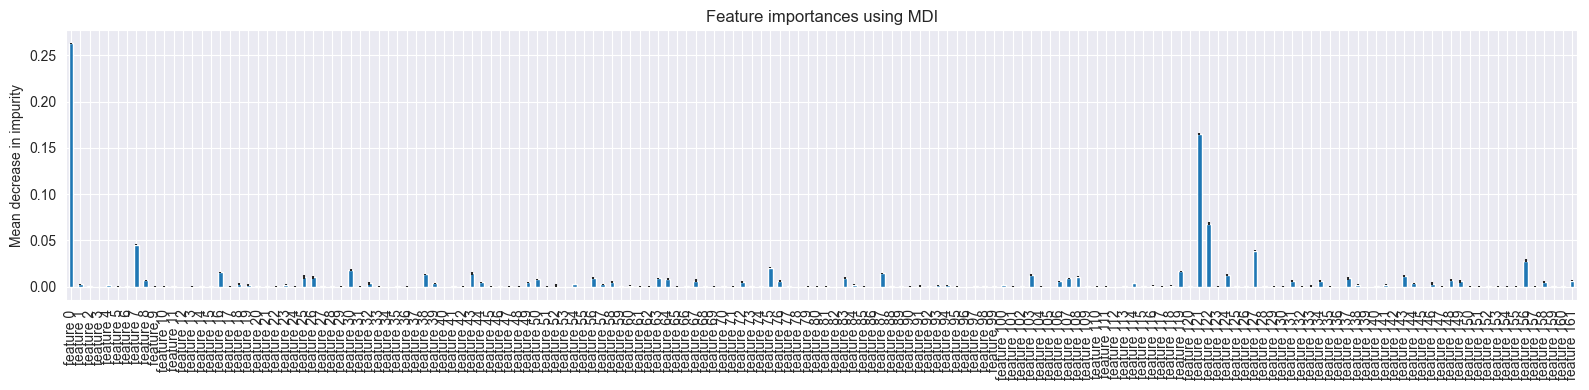

In [25]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(16, 4))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [26]:
from sklearn.inspection import permutation_importance

In [27]:
result = permutation_importance(
    best_estimator, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

/Users/wolfrieder/Documents/github_repos/thesis_project_v2/venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(

KeyboardInterrupt

